<a href="https://colab.research.google.com/github/johnnycleiton07/llm-studies/blob/main/Analise_de_sentimentos_supervisionado_x_regras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de sentimentos: Supervisionado x Regras

A análise de sentimentos pode ser realizada por métodos supervisionados ou baseados em regras. No método supervisionado, modelos de aprendizado de máquina são treinados em um conjunto de dados rotulados para aprender padrões e prever sentimentos em novos textos, oferecendo alta precisão quando há grandes quantidades de dados de treinamento.

Por outro lado, a abordagem baseada em regras, como a biblioteca `VADER`, utiliza dicionários de sentimentos e regras heurísticas para atribuir sentimentos aos textos, sendo eficiente para textos curtos e informais, mas pode não captar nuances contextuais tão bem quanto os modelos supervisionados.

##Configurações iniciais

In [1]:
import pandas as pd
from google.colab import files
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#dataset escolhido para este exemplo: Tweets2
files.upload()

In [5]:
Tweets = pd.read_csv("Tweets2.csv")
Tweets.shape

(74682, 4)

In [6]:
Tweets.head()

,id,local,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


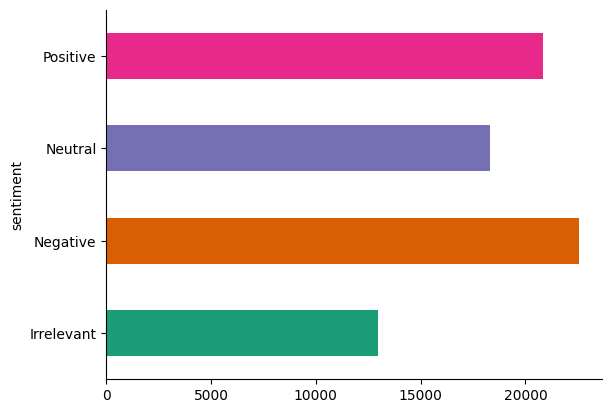

In [7]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
Tweets.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
Tweets.groupby(['sentiment']).size()

sentiment
Irrelevant    12990
Negative      22542
Neutral       18318
Positive      20832
dtype: int64

In [9]:
Tweets.loc[Tweets['sentiment']=='Irrelevant','sentiment'] = 'Neutral'

In [10]:
Tweets = Tweets.dropna(subset=['text'])
Tweets.reset_index(drop=True, inplace=True)

In [11]:
Tweets.shape

(73996, 4)

#Supervisionado

In [12]:
token = Tokenizer(num_words=100)
token.fit_on_texts(Tweets['text'].values)

In [13]:
X = token.texts_to_sequences(Tweets['text'].values)
X = pad_sequences(X, padding="post", maxlen=100)

In [14]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(Tweets['sentiment'])
print(y)

[2 2 2 ... 2 2 2]


In [15]:
y = to_categorical(y)
print(y)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4)
X_test

array([[ 5,  6, 85, ...,  0,  0,  0],
       [97,  1, 60, ...,  0,  0,  0],
       [70,  1, 25, ...,  0,  0,  0],
       ...,
       [62,  6,  1, ...,  0,  0,  0],
       [ 9, 64,  8, ...,  0,  0,  0],
       [74, 63,  0, ...,  0,  0,  0]], dtype=int32)

In [17]:
modelo = Sequential()
modelo.add(Embedding(input_dim= len(token.word_index), output_dim=128, input_length=X.shape[1]))
modelo.add(SpatialDropout1D(0.2))
modelo.add(LSTM(units=196, dropout=0.2, recurrent_dropout=0, activation='tanh',
                recurrent_activation='sigmoid', unroll=False, use_bias=True))
modelo.add(Dense(units=3,activation="softmax"))

In [18]:
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(modelo.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          4324224   
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 128)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 4579615 (17.47 MB)
Trainable params: 4579615 (17.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
modelo.fit(X_train, y_train, epochs=5, batch_size=500,verbose=True)

Epoch 1/5
89/89 [==============================] - 189s 2s/step - loss: 1.0835 - accuracy: 0.4170
Epoch 2/5
89/89 [==============================] - 182s 2s/step - loss: 1.0829 - accuracy: 0.4181
Epoch 3/5
89/89 [==============================] - 179s 2s/step - loss: 1.0829 - accuracy: 0.4181
Epoch 4/5
89/89 [==============================] - 180s 2s/step - loss: 1.0829 - accuracy: 0.4181
Epoch 5/5
89/89 [==============================] - 180s 2s/step - loss: 1.0828 - accuracy: 0.4181


In [20]:
_, accuracy = modelo.evaluate(X_test,y_test)
print("Accuracy: ", accuracy)

925/925 [==============================] - 79s 85ms/step - loss: 1.0824 - accuracy: 0.4196
Accuracy:  0.4196087718009949


#A base de Regras - VADER

In [21]:
#from pandas.core.internals.managers import T
mas = SentimentIntensityAnalyzer()
Tweets['vander_sentiment'] = ''

for y in range(len(Tweets.index)):
  x = mas.polarity_scores(Tweets['text'].iloc[y])
  del x['compound']
  maior = max(x,key=x.get) #neg pos neu
  Tweets.loc[y,'vander_sentiment'] = maior

In [22]:
Tweets.groupby(['vander_sentiment']).size()

vander_sentiment
neg     3660
neu    65581
pos     4755
dtype: int64

In [23]:
Tweets.groupby(['sentiment']).size()

sentiment
Negative    22358
Neutral     30983
Positive    20655
dtype: int64

In [24]:
Tweets.loc[Tweets['vander_sentiment']== 'neu' , 'vander_sentiment'] = 'Neutral'
Tweets.loc[Tweets['vander_sentiment']== 'neg' , 'vander_sentiment'] = 'Negative'
Tweets.loc[Tweets['vander_sentiment']== 'pos' , 'vander_sentiment'] = 'Positive'

In [25]:
Tweets.groupby(['vander_sentiment']).size()

vander_sentiment
Negative     3660
Neutral     65581
Positive     4755
dtype: int64

In [26]:
y_pred = Tweets['vander_sentiment']
y_test = Tweets['sentiment']
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 2004 19902   452]
 [ 1122 28384  1477]
 [  534 17295  2826]]


In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.44886210065408944
